<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/Dec18_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CALIBRATED PARAMETERS
J_in = 5.68 #/cm3/s
C_g  = 0.0000 µm/s
K    = 6.39e-23 cm3/s
beta = 2.52e-05 s^-1 µm^-2 (from H)


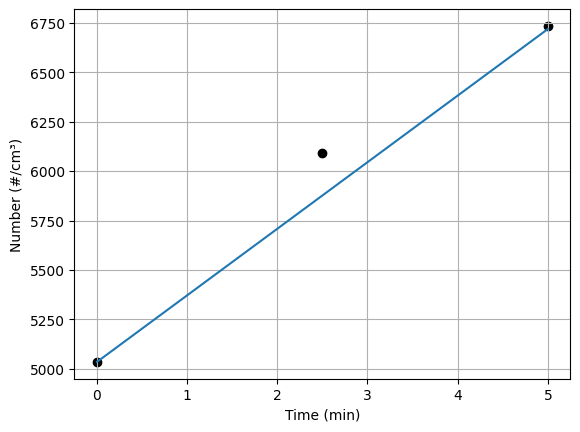

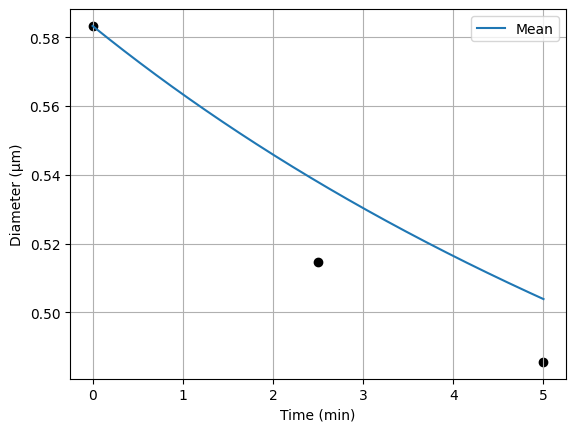

In [8]:
# All models with physical sedimentation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ============================================================
# SYSTEM GEOMETRY & PHYSICS
# ============================================================
rho_p = 1000      # kg/m3
rho_g = 1.2       # kg/m3
mu = 1.8e-5       # Pa s
g = 9.81          # m/s2
H = 1.2           # m  <-- chamber height

beta = (rho_p - rho_g) * g / (18 * mu * H)
beta *= 1e-12     # convert to s^-1 µm^-2

# ============================================================
# APS MEASUREMENTS
# ============================================================
t_data = np.array([0, 150, 300])
M_data = np.array([
    [5035, 2937, 2860, 8382],
    [6091, 3135, 2553, 7743],
    [6734, 3270, 2438, 8130]
])

din = 0.3  # µm

# ============================================================
# QMOM (2-node)
# ============================================================
def qmom_nodes(M):
    M0, M1, M2, M3 = M
    mu_d = M1 / M0
    var = max(M2 / M0 - mu_d**2, 1e-12)
    std = np.sqrt(var)
    return 0.5*M0, mu_d - std, 0.5*M0, mu_d + std

# ============================================================
# MOMENT ODEs
# ============================================================
def moment_rhs(t, y, Jin, Cg, K):
    M0, M1, M2, M3 = y
    M0 = max(M0, 1e-9)

    w1, d1, w2, d2 = qmom_nodes(y)
    M4 = w1*d1**4 + w2*d2**4
    M5 = w1*d1**5 + w2*d2**5

    dM0 = Jin - 0.5*K*M0**2 - beta*M2
    dM1 = Jin*din + Cg*M0 - beta*M3
    dM2 = Jin*din**2 + 2*Cg*M1 + K*M1**2 - beta*M4
    dM3 = Jin*din**3 + 3*Cg*M2 + 3*K*M1*M2 - beta*M5

    return [dM0, dM1, dM2, dM3]

# ============================================================
# CALIBRATION
# ============================================================
def residuals(params):
    Jin, Cg, K = params
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
        [0, 300],
        M_data[0],
        t_eval=t_data
    )
    return (sol.y.T - M_data).ravel()

res = least_squares(
    residuals,
    [10, 0.004, 1e-10],
    bounds=([0, 0, 0], [50, 0.02, 1e-8])
)

Jin, Cg, K = res.x

print("\nCALIBRATED PARAMETERS")
print(f"J_in = {Jin:.2f} #/cm3/s")
print(f"C_g  = {Cg:.4f} µm/s")
print(f"K    = {K:.2e} cm3/s")
print(f"beta = {beta:.2e} s^-1 µm^-2 (from H)")

# ============================================================
# FULL SOLUTION
# ============================================================
t = np.linspace(0, 300, 400)
sol = solve_ivp(
    lambda t, y: moment_rhs(t, y, Jin, Cg, K),
    [0, 300],
    M_data[0],
    t_eval=t
)

M0, M1, M2, M3 = sol.y
mean_d = M1 / M0

# Mode estimate
mode = np.zeros_like(mean_d)
for i in range(len(t)):
    w1, d1, w2, d2 = qmom_nodes([M0[i], M1[i], M2[i], M3[i]])
    mode[i] = d1 if w1 > w2 else d2

# ============================================================
# PLOTS
# ============================================================
plt.figure()
plt.plot(t/60, M0)
plt.scatter(t_data/60, M_data[:,0], c='k')
plt.ylabel("Number (#/cm³)")
plt.xlabel("Time (min)")
plt.grid()

plt.figure()
plt.plot(t/60, mean_d, label="Mean")
#plt.plot(t/60, mode, '--', label="Mode")
plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
plt.ylabel("Diameter (µm)")
plt.xlabel("Time (min)")
plt.legend()
plt.grid()
plt.show()

np.savetxt('data.csv', (t/60, M0, mean_d), delimiter=',')